In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
import matplotlib.pyplot as plt

In [14]:
# Load dataset (MNIST for simplicity)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

In [16]:
# Define diffusion model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
diffusion_model = UNet2DModel(sample_size=28, in_channels=1, out_channels=1, layers_per_block=2, 
    block_out_channels=[32, 64],  # Only 2 blocks
    down_block_types=("DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D")).to(device)
scheduler = DDPMScheduler(num_train_timesteps=500)
optimizer = optim.Adam(diffusion_model.parameters(), lr=1e-4)

print("Expected UNet input size:", diffusion_model.config.sample_size)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Train diffusion model directly on image space
for epoch in range(3):
    print('Epoch', epoch)
    for i, (x, _) in enumerate(dataloader):
        print(i)
        x = x.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 500, (x.shape[0],), device=device)
        noisy_x = scheduler.add_noise(x, noise, timesteps)

        # print(x.shape)
        # print(timesteps[0])
        # x = noisy_x[0].squeeze(0).cpu().numpy() 
        # plt.imshow(x, cmap="gray")
        # plt.show()
        # print(noise[0])

        pred_noise = diffusion_model(noisy_x, timesteps).sample
        loss = ((pred_noise - noise) ** 2).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch 0
0


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# # Train diffusion model
# for epoch in range(3):  # Small number of epochs for demonstration
#     for x, _ in dataloader:
#         print('xdim', x.shape)
#         x = x.to(device)
#         noise = torch.randn_like(x)
#         timesteps = torch.randint(0, 500, (x.shape[0],), device=device)
#         noisy_x = scheduler.add_noise(x, noise, timesteps)
#         print(noisy_x.shape, timesteps.dtype, noise.shape, noise.dtype)
#         pred_noise = diffusion_model(noisy_x, timesteps).sample
#         loss = ((pred_noise - noise) ** 2).mean()
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

In [ ]:
# Get 20% diffusion steps output
def get_noised_images(x, timesteps=200):
    noise = torch.randn_like(x)
    return scheduler.add_noise(x, noise, torch.full((x.shape[0],), timesteps, device=device))

# Prepare dataset for VAE
vae_inputs, vae_targets = [], []
for x, _ in dataloader:
    x = x.to(device)
    vae_inputs.append(x)
    vae_targets.append(get_noised_images(x))
vae_inputs, vae_targets = torch.cat(vae_inputs), torch.cat(vae_targets)

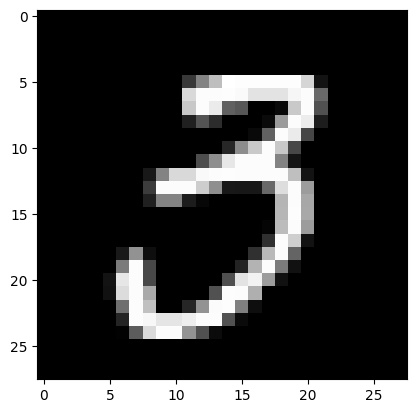

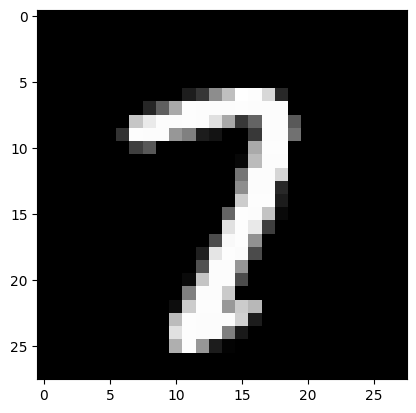

In [ ]:
def show_img(inp):
    img = inp.squeeze(0).cpu().numpy() 
    plt.imshow(img, cmap="gray")
    plt.show()

show_img(vae_inputs[1])
show_img(vae_inputs[2])

In [ ]:
# Define simple VAE
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 128), nn.ReLU(), nn.Linear(128, 32))
        self.decoder = nn.Sequential(nn.Linear(32, 128), nn.ReLU(), nn.Linear(128, 28*28), nn.Unflatten(1, (1, 28, 28)))
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

vae = VAE().to(device)
vae_optimizer = optim.Adam(vae.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train VAE
for epoch in range(10):
    print('epoch', epoch)
    for i in range(0, len(vae_inputs), 64):
        x_batch = vae_inputs[i:i+64].to(device)
        target_batch = vae_targets[i:i+64].to(device)
        output = vae(x_batch)
        loss = loss_fn(output, target_batch)
        vae_optimizer.zero_grad()
        loss.backward()
        vae_optimizer.step()



epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


In [ ]:
with torch.no_grad():
    latent_samples = torch.randn(16, 32, device=device)  # Sample from latent space

    latent_samples[0] = vae.encoder(vae_inputs[1]).flatten()
    latent_samples[1] = vae.encoder(vae_inputs[2]).flatten()
    latent_samples[2] = 0.5 * latent_samples[0] + 0.5*latent_samples[1]

In [ ]:
# Sampling
with torch.no_grad():
    vae_output = vae.decoder(latent_samples)

    sampled = vae_output  # Start from D(x), which is the noisy image at t=100
    timesteps = list(range(200, -1, -1))  # Reverse diffusion from t=100 to t=0
    for t in timesteps:
        timestep = torch.full((sampled.shape[0],), t, device=device)
        noise_pred = diffusion_model(sampled, timestep).sample  # Predict noise
        sampled = scheduler.step(noise_pred, t, sampled).prev_sample  # Reverse diffusion step

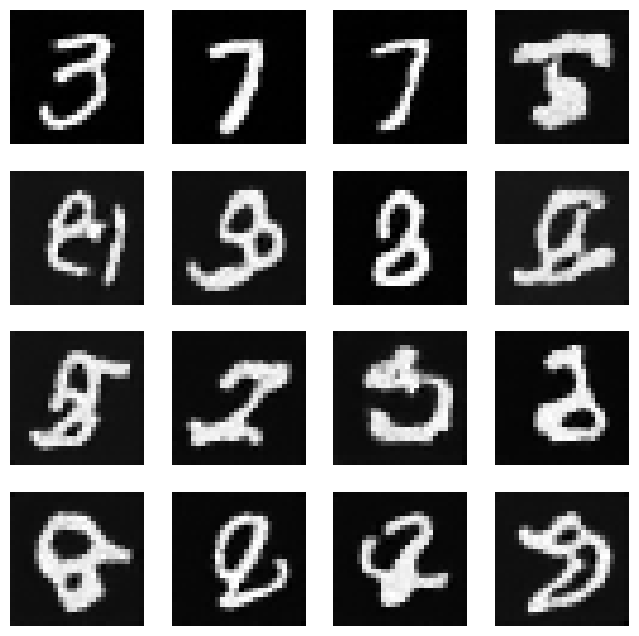

In [ ]:
# samples = vae_xx_output_diffused.cpu().numpy().squeeze()  # Shape: (16, 28, 28)
samples = sampled.cpu().numpy().squeeze()  # Shape: (16, 28, 28)

# Plot a few generated images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i], cmap="gray")
    ax.axis("off")  # Hide axis

plt.show()

In [ ]:
# Blurring experiment